In [1]:
# basic
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
# pre processing
from sklearn import preprocessing as pre
# NN
import torch
import torch.nn as nn
from torch import Tensor
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import MSELoss
from torch_geometric.nn import GCNConv
# val and plot
from torchmetrics.regression import R2Score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from loguru import logger as log
# ours libs
from data import load_dataset
from val import calculate_metrics
# plot
import matplotlib.pyplot as plt

In [2]:
plt.style.use('seaborn-whitegrid')
#pd.set_option('display.float_format', '{:.16f}'.format)

## Data

In [3]:
df_nodes = pd.read_csv('../../data/graph_designer/train_test/df_nodes_selected.csv')
nodes = list(df_nodes.tensor_idx.values)

## Models

In [4]:
models = ['lstm', 'gru', 'gcn', 'cheb', 'sage',  'gat', 'gconv_lstm', 'gconv_gru', 'tgcn', 'dcrnn', 'a3tgcn']

In [5]:
model = models[4]
model

'sage'

In [6]:
df_test = pd.read_csv(f'../../outputs/regression/same_env/forecasting/{model}_forecasting.csv')
df_test['time'] = pd.to_datetime(df_test['time'])
df_test.head()

,time,day,partition,partition_nn,carregamento_node_694,carregamento_node_2772,carregamento_node_1203,carregamento_node_592,carregamento_node_561,y_pred_694,y_pred_2772,y_pred_1203,y_pred_592,y_pred_561
0,2024-03-08 00:00:00,8,test,test,26.666667,24.583333,0.25,2.5,17.583333,32.817673,29.880890,1.759834,2.806606,18.470778
1,2024-03-08 00:05:00,8,test,test,24.416667,24.833333,0.50,2.5,11.416667,30.313046,26.998234,1.552542,2.964595,17.572159
2,2024-03-08 00:10:00,8,test,test,18.000000,18.000000,0.50,1.5,11.166667,28.740140,25.475756,1.789780,3.126051,15.676132
3,2024-03-08 00:15:00,8,test,test,18.250000,12.916667,0.50,1.5,9.333333,28.442848,26.761976,1.037367,3.193348,14.765747
4,2024-03-08 00:20:00,8,test,test,15.416667,8.666667,0.50,1.5,9.250000,23.075804,20.293003,1.126486,3.490373,13.975140


In [7]:
df_result = pd.read_csv(f'../../outputs/regression/same_env/forecasting/{model}_metrics.csv')
df_result.head()

,mse,mae,rmse,mape,r2,node
0,2608.901680,30.177615,51.077409,3.212106e-01,0.915734,694
1,2185.337552,30.576640,46.747594,3.210972e-01,0.877399,2772
2,148.183619,8.689405,12.173069,1.230708e+14,0.895440,1203
3,89.015810,5.932582,9.434819,1.789902e+14,0.694600,592
4,1265.806230,19.170319,35.578171,3.632712e-01,0.896658,561


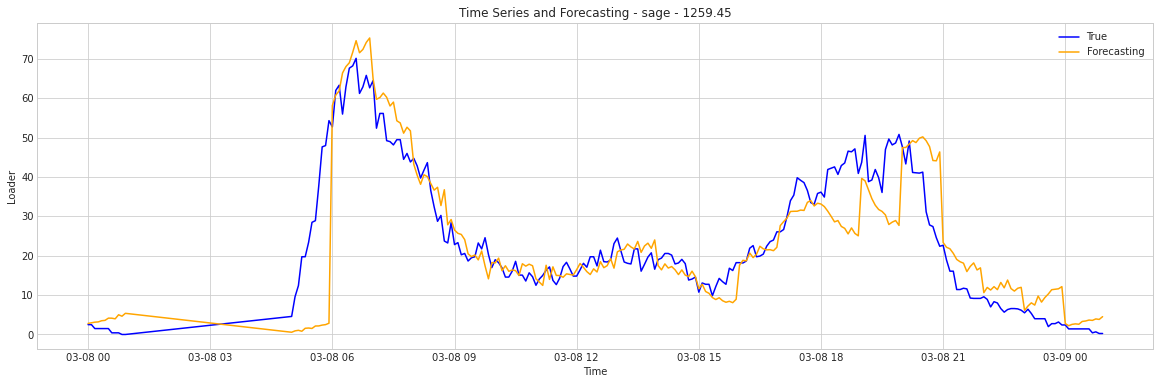

In [8]:
node = nodes[3]
plt.figure(figsize=(20, 6))
plt.plot(df_test.time, df_test[f"carregamento_node_{node}"], label=f'True', color='blue')
plt.plot(df_test.time, df_test[f"y_pred_{node}"], label=f'Forecasting', color='orange')
plt.xlabel('Time')
plt.ylabel('Loader')
plt.title(f'Time Series and Forecasting - {model} - {np.mean(df_result.mse.values):.2f}')
plt.legend()
plt.show()

In [9]:
np.mean(df_result.mse)

1259.4489780587355

In [10]:
scores = ['mse', 'mae', 'rmse', 'mape', 'r2']
for mn in scores:
    print(f"{mn} : {np.mean(df_result[mn].values)} +- {np.std(df_result[mn].values)}")
    

mse : 1259.4489780587355 +- 1027.925791230419
mae : 18.90931219359239 +- 10.353852660535564
rmse : 31.002212377399825 +- 17.271705351971825
mape : 60412214053104.984 +- 76073329361844.98
r2 : 0.855966027198656 +- 0.08159010825190324


In [11]:
df_result.std()

mse     1.149256e+03
mae     1.157596e+01
rmse    1.931035e+01
mape    8.505257e+13
r2      9.122051e-02
node    9.352643e+02
dtype: float64

In [12]:
df_scores = pd.read_csv(f'../../outputs/regression/same_env/train_loss/loss_{model}.csv')
df_scores.head()

,Epochs,loss
0,1,1083.31710
1,2,977.99164
2,3,884.48270
3,4,801.32477
4,5,727.25730


<AxesSubplot:>

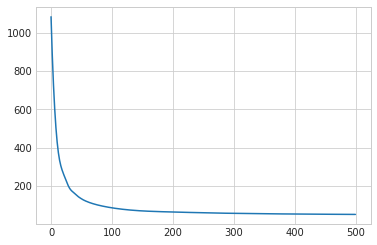

In [13]:
df_scores['loss'].plot()

In [14]:
df_test.head()

,time,day,partition,partition_nn,carregamento_node_694,carregamento_node_2772,carregamento_node_1203,carregamento_node_592,carregamento_node_561,y_pred_694,y_pred_2772,y_pred_1203,y_pred_592,y_pred_561
0,2024-03-08 00:00:00,8,test,test,26.666667,24.583333,0.25,2.5,17.583333,32.817673,29.880890,1.759834,2.806606,18.470778
1,2024-03-08 00:05:00,8,test,test,24.416667,24.833333,0.50,2.5,11.416667,30.313046,26.998234,1.552542,2.964595,17.572159
2,2024-03-08 00:10:00,8,test,test,18.000000,18.000000,0.50,1.5,11.166667,28.740140,25.475756,1.789780,3.126051,15.676132
3,2024-03-08 00:15:00,8,test,test,18.250000,12.916667,0.50,1.5,9.333333,28.442848,26.761976,1.037367,3.193348,14.765747
4,2024-03-08 00:20:00,8,test,test,15.416667,8.666667,0.50,1.5,9.250000,23.075804,20.293003,1.126486,3.490373,13.975140


In [15]:
#labels_time = ['12AM', '3AM', '6AM', '9AM', '12PM', '3PM', '18PM', '21PM', '12AM'] 

In [16]:
# xlabels_pos = ['2024-03-08 00:00:00', 
#               '2024-03-08 03:00:00',
#               '2024-03-08 06:00:00',
#               '2024-03-08 09:00:00',
#               '2024-03-08 12:00:00',
#               '2024-03-08 15:00:00',
#               '2024-03-08 18:00:00',
#               '2024-03-08 21:00:00',
#               '2024-03-09 00:00:00']

In [17]:
#pos_dt = pd.to_datetime(xlabels_pos)

In [18]:
# plt.figure(figsize=(20, 8))
# plt.plot(df_test.time, df_test[f"carregamento_node_{node}"], label=f'Ground Truth', color='blue', linewidth=2.5)

# for model in models:
    
#     df_result_model = pd.read_csv(f'../../outputs/regression/same_env/forecasting/{model}_forecasting.csv')
#     plt.plot(df_test.time, df_result_model[f"y_pred_{node}"], 
#              label=f' {model.upper()}', linewidth=1.5)
    
# plt.xlabel('Time', fontsize=25)
# plt.ylabel('Loader', fontsize=25)
# #plt.title(f'Time Series and Forecasting - {model} - {np.mean(df_result.mse.values):.2f}')
# plt.legend(fontsize=18)
# plt.xticks(pos_dt, labels_time, fontsize=18)  # Increase x-tick font size
# plt.yticks(fontsize=18)  # Increase x-tick font size
# plt.savefig('forecasting_all_models.png', dpi=600, bbox_inches='tight')
# plt.show()

## Fix MAPE

In [19]:
node = nodes[3]
node

592

In [20]:
df_test.head()

,time,day,partition,partition_nn,carregamento_node_694,carregamento_node_2772,carregamento_node_1203,carregamento_node_592,carregamento_node_561,y_pred_694,y_pred_2772,y_pred_1203,y_pred_592,y_pred_561
0,2024-03-08 00:00:00,8,test,test,26.666667,24.583333,0.25,2.5,17.583333,32.817673,29.880890,1.759834,2.806606,18.470778
1,2024-03-08 00:05:00,8,test,test,24.416667,24.833333,0.50,2.5,11.416667,30.313046,26.998234,1.552542,2.964595,17.572159
2,2024-03-08 00:10:00,8,test,test,18.000000,18.000000,0.50,1.5,11.166667,28.740140,25.475756,1.789780,3.126051,15.676132
3,2024-03-08 00:15:00,8,test,test,18.250000,12.916667,0.50,1.5,9.333333,28.442848,26.761976,1.037367,3.193348,14.765747
4,2024-03-08 00:20:00,8,test,test,15.416667,8.666667,0.50,1.5,9.250000,23.075804,20.293003,1.126486,3.490373,13.975140


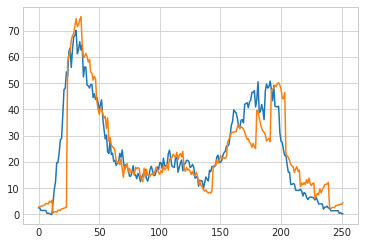

In [21]:
plt.plot(df_test[f'carregamento_node_{node}'])
plt.plot(df_test[f'y_pred_{node}'])
plt.show()

In [22]:
def mean_absolute_percentage_error_np(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [24]:
mapes = []
for nd in nodes:
    y_true = df_test[f'carregamento_node_{nd}']+1
    y_pred = df_test[f'y_pred_{nd}']+1
    mape       = mean_absolute_percentage_error(y_true, y_pred)
    mape_stats = mean_absolute_percentage_error_np(y_true, y_pred)
    print(f"node {node} - MAPE: {mape} MAPE np: {mape_stats:.2f}")
    mapes.append(mape)

node 592 - MAPE: 0.28685632295546576 MAPE np: 28.69
node 592 - MAPE: 0.28897393924773074 MAPE np: 28.90
node 592 - MAPE: 0.33012745198685317 MAPE np: 33.01
node 592 - MAPE: 0.42775373468840466 MAPE np: 42.78
node 592 - MAPE: 0.3058586860634061 MAPE np: 30.59


In [ ]:
dir(sm.tools.eval_measures)

In [ ]:
sum(np.array(mapes)) / len(mapes)

In [ ]:
np.array(mapes).mean() , np.array(mapes).std() 

In [ ]:
model